***Importing Libraries***

In [17]:
import warnings
import logging
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)


***Preparing data***

In [18]:
df = pd.read_csv('btc.csv')

In [19]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [20]:
data = df['Close'].values

In [21]:
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

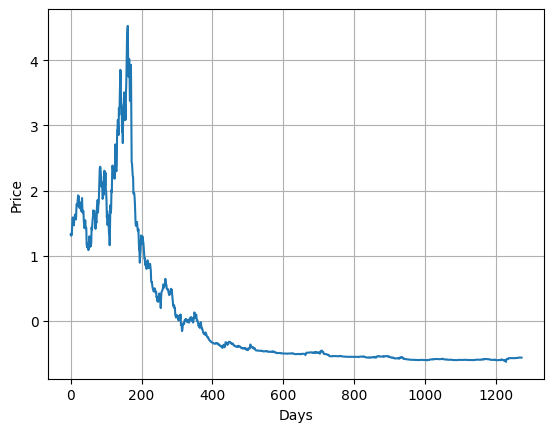

In [22]:
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()

In [23]:
def get_data(data, window_size):
    X = []
    y = []
    
    i = 0
    
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [24]:
X, y = get_data(data, window_size = 7)

In [25]:
#train set
X_train  = np.array(X[:1000])
y_train = np.array(y[:1000])

#test set
X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

In [26]:
X_train.shape

(1000, 7, 1)

***Defining network parameters***

In [27]:
batch_size = 7
window_size = 7 
hidden_layer = 256 
learning_rate = 0.001 

***Defining placeholders***

In [28]:
input = tf.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.placeholder(tf.float32, [batch_size, 1])

***Defining weights***

Weights of input gate

In [29]:
U_i = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.Variable(tf.zeros([hidden_layer]))

Weights of forget gate

In [30]:
U_f = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.Variable(tf.zeros([hidden_layer]))

Weights of output gate

In [31]:
U_o = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.zeros([hidden_layer]))

Weights of candidate gate

In [32]:
U_g = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.zeros([hidden_layer]))

Output layer weight

In [33]:
V = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))

***Defining LSTM Cell***

In [34]:
def LSTM_cell(input, prev_hidden_state, prev_cell_state):

    it = tf.sigmoid(tf.matmul(input, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)

    ft = tf.sigmoid(tf.matmul(input, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)

    ot = tf.sigmoid(tf.matmul(input, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)

    gt = tf.tanh(tf.matmul(input, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)

    ct = (prev_cell_state * ft) + (it * gt)

    ht = ot * tf.tanh(ct)

    return ct, ht

***Defining forward propagation***

In [35]:
#initialize the list called y_hat for storing the predicted output
y_hat = []

#for each batch we compute the output and store it in the y_hat list
for i in range(batch_size): 
  
    #initialize hidden state and cell state for each batch
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)
    
    
    #compute the hidden state and cell state of the LSTM cell for each time step
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state)
        
    #compute y_hat and append it to y_hat list
    y_hat.append(tf.matmul(hidden_state, V) + b_v)

***Defining backpropagation***

In [36]:
losses = []

for i in range(len(y_hat)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(target[i], (-1, 1)), y_hat[i]))
    
loss = tf.reduce_mean(losses)

In [37]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.trainable_variables()))

***Training the LSTM model***

In [39]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [40]:
epochs = 100

In [41]:
for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []
    
    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):
        
        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        
        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})
        
        #store the loss
        epoch_loss.append(loss_val)
        
        #store the predictions
        train_predictions.append(predicted)
        index += batch_size
        
        
    #print the loss on every 10 iterations
    if (i % 10)== 0:
        print(f'Epoch {i}, Loss: {np.mean(epoch_loss)}')

Epoch 0, Loss: 0.1983027309179306
Epoch 10, Loss: 0.048380881547927856
Epoch 20, Loss: 0.028108010068535805
Epoch 30, Loss: 0.021589545533061028
Epoch 40, Loss: 0.008969377726316452
Epoch 50, Loss: 0.011092914268374443
Epoch 60, Loss: 0.011774963699281216
Epoch 70, Loss: 0.008624892681837082
Epoch 80, Loss: 0.008083450607955456
Epoch 90, Loss: 0.007165234535932541


***Making predictions using the LSTM model***

In [42]:
predicted_output = []
i = 0
while i+batch_size <= len(X_test): 
  
    output = session.run([y_hat],feed_dict={input:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)

In [43]:
predicted_output[0]

[[array([[-0.60435253]], dtype=float32),
  array([[-0.6017415]], dtype=float32),
  array([[-0.6009271]], dtype=float32),
  array([[-0.59931946]], dtype=float32),
  array([[-0.59928614]], dtype=float32),
  array([[-0.600866]], dtype=float32),
  array([[-0.59698176]], dtype=float32)]]

In [44]:
predicted_values_test = []
for i in range(len(predicted_output)):
  for j in range(len(predicted_output[i][0])):
    predicted_values_test.append(predicted_output[i][0][j])

In [45]:
predicted_values_test[0]

array([[-0.60435253]], dtype=float32)

In [46]:
predictions = []
for i in range(1280):
      if i >= 1000:
        predictions.append(predicted_values_test[i-1019])
      else:
        predictions.append(None)

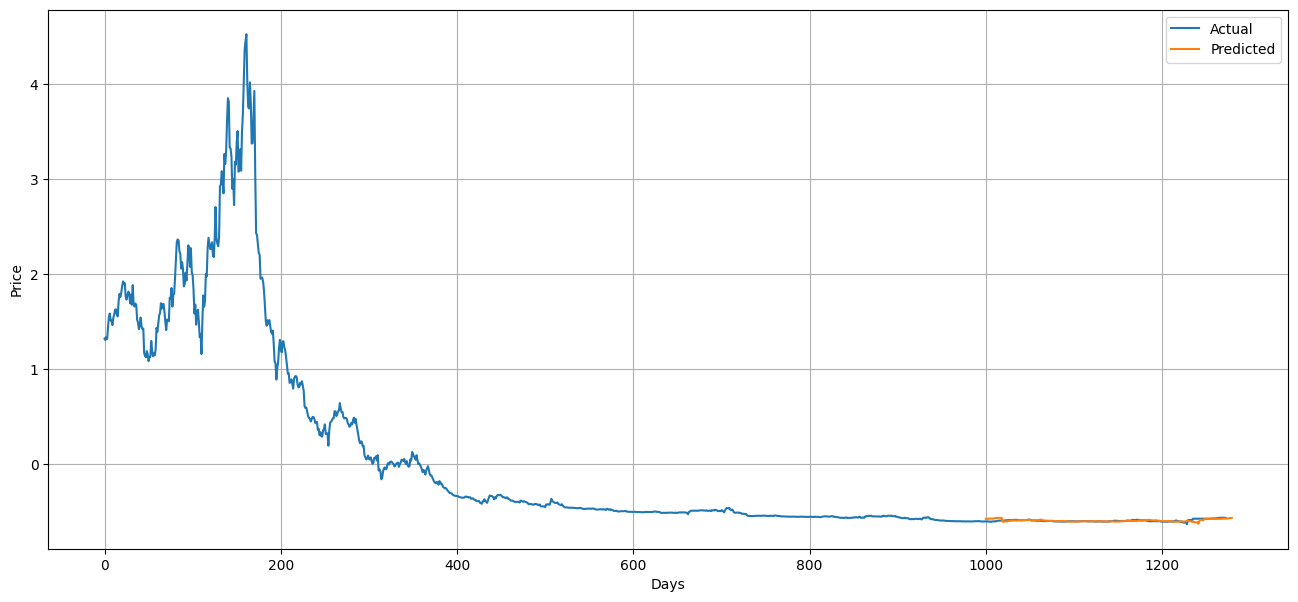

In [47]:
plt.figure(figsize=(16, 7))
plt.plot(data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()
plt.show()

We can see that the actual value is shown in red color and the predicted value is shown in blue color. As we are making predictions for the time step greater than 1000, we observe that, red and blue lines interest each other, which implies that our model has correctly predicted the actual values.